In [1]:
pip install openpyxl

     |████████████████████████████████| 243 kB 861 kB/s 
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8913 sha256=d970bced4720ab0fbd51fad208cd5936286dc765b8abbc9d2944dc8c90ee196f
  Stored in directory: /root/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-learn-extra

     |████████████████████████████████| 1.7 MB 874 kB/s 
Note: you may need to restart the kernel to use updated packages.


### Librerías

In [3]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import missingno as msno
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.manifold import SpectralEmbedding
import seaborn as sns
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import pairwise_distances
from scipy import sparse
from sklearn_extra.cluster import KMedoids
from scipy import linalg
import missingno as msno

### Data

In [4]:
df = pd.read_excel( '../input/lung-cancer-proyecto-iii/Base_inmunosenescencia_v10.xlsx', sheet_name = 'Data' )
vbles_count = [ "Neutrofilos", "Linf_tot", "Plaquetas", "LinfT_cel", "CD4_cel", "CD8_cel", "CD4:CD8", "LinfB_cel", "LinfNK_cel", 
  "HLADR+Lin_C_Leuc", "mDC_C_Leuc", "pDC_C_Leuc", "CD4_Central_Mem_C_Linf", "CD4_Effector_Mem_C_Linf", "CD4_Naïve_C_Linf", "CD4_TEMRA_C_Linf", 
  "CD8_Central_Mem_C_Linf", "CD8_Effector_Mem_C_Linf", "CD8_Naïve_C_Linf", "CD8_TEMRA_C_Linf", "mDC_CD16_C_mDC", "mDC_CD1c_C_mDC", 
  "mDC_Clec9A_C_mDC", "CD27-CD57+CD3+_C_Linf", "CD27-CD57+CD4+_C_CD3", "CD27-CD57+CD8+_C_CD3", "CD45RA+CCR7+CD3+_C_Linf", "CD8+_term_efect_C_CD3", 
  "CD8_exhausted_C_CD3", "CD4_TCR_ab+_C_CD3", "CD4+_C_Linf", "CD8+_TCR_ab+_C_CD3", "CD8+_C_Linf", "CD8+CD4+_C_Linf", "CD8-CD4-_C_Linf", "HLADR+CD3+_C_Linf", 
  "TCR_ab+_C_Linf", "TCR_gd+_C_Linf", "gd_VD1+_C_CD3", "gd_VD1+VD2+_C_CD3", "gd_VD1-VD2-_C_CD3", "gd_VD2+_C_CD3", "CD25+CD4+_C_Linf" ]
X = df[vbles_count]
X_std = StandardScaler().fit_transform(X)

#le_embedding = df[['le_1', 'le_2', 'le_3']].values

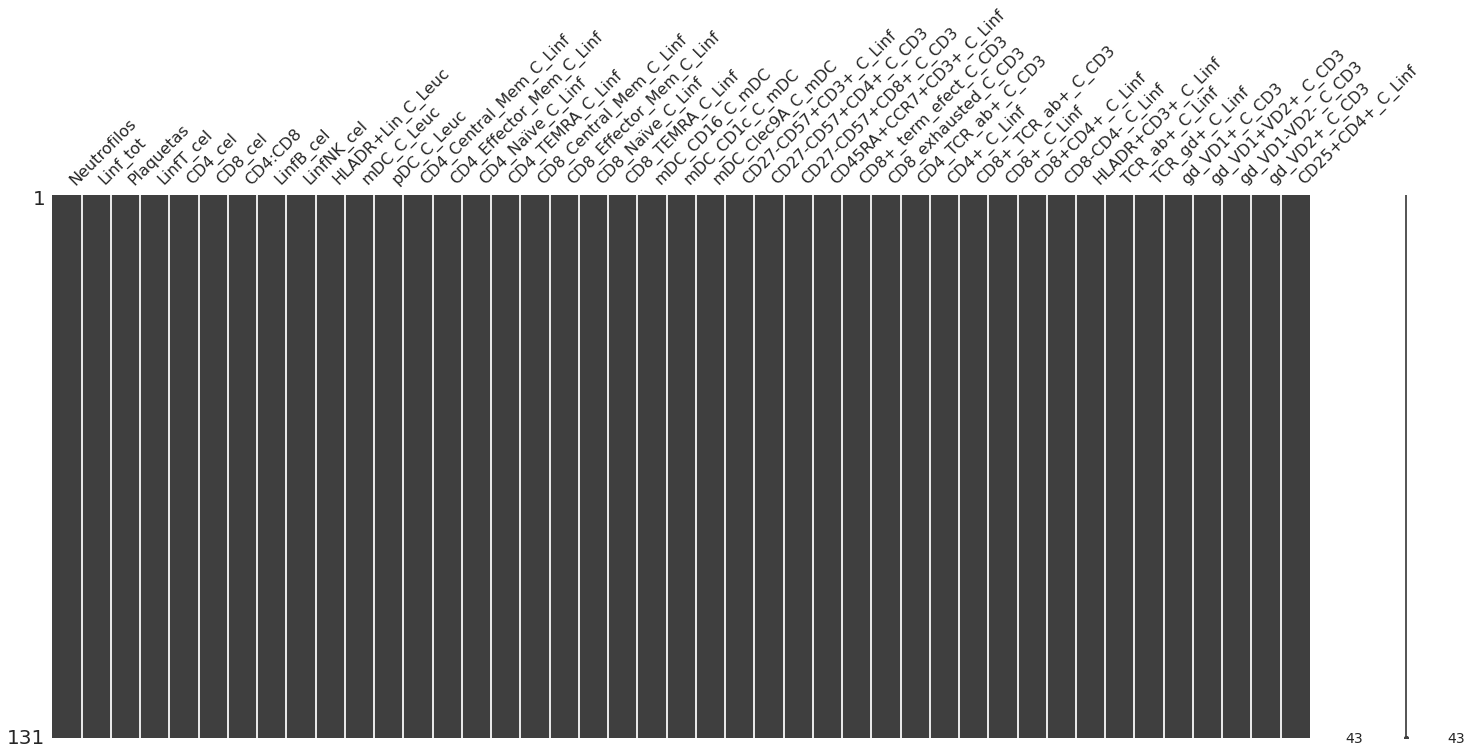

In [5]:
msno.matrix(X)
plt.show()

### Spectral clustering

#### Compute Graph Laplacian

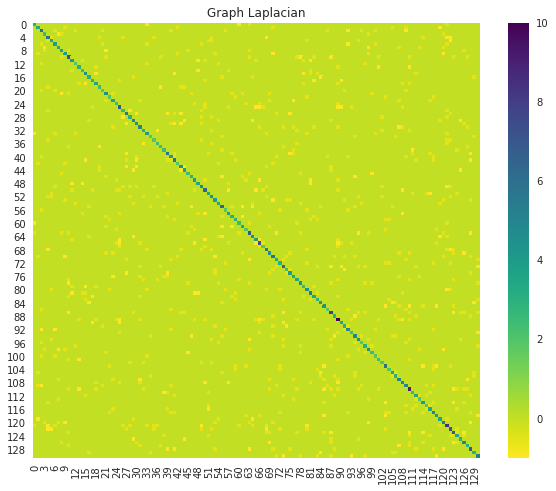

In [6]:
def generate_graph_laplacian(df, nn):
    """Generate graph Laplacian from data."""
    # Adjacency Matrix.
    connectivity = kneighbors_graph(X=df, n_neighbors=nn, mode='connectivity')
    adjacency_matrix_s = (1/2)*(connectivity + connectivity.T)
    # Graph Laplacian.
    graph_laplacian_s = sparse.csgraph.laplacian(csgraph=adjacency_matrix_s, normed=False)
    graph_laplacian = graph_laplacian_s.toarray()
    return graph_laplacian 
    
graph_laplacian = generate_graph_laplacian(df=X_std, nn=4)

# Plot the graph Laplacian as heat map.
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(graph_laplacian, ax=ax, cmap='viridis_r')
ax.set(title='Graph Laplacian');

#### Compute Spectrum of the Graph Laplacian

In [7]:
eigenvals, eigenvcts = linalg.eig(graph_laplacian)

The eigenvalues are represented by complex numbers. Since the graph Laplacian is a symmetric matrix, we know by the spectral theorem that all the eigenvalues must be real. Let us verify this:

In [8]:
np.unique(np.imag(eigenvals))

array([0.])

In [9]:
# We project onto the real numbers. 
def compute_spectrum_graph_laplacian(graph_laplacian):
    """Compute eigenvalues and eigenvectors and project 
    them onto the real numbers.
    """
    eigenvals, eigenvcts = linalg.eig(graph_laplacian)
    eigenvals = np.real(eigenvals)
    eigenvcts = np.real(eigenvcts)
    return eigenvals, eigenvcts

eigenvals, eigenvcts = compute_spectrum_graph_laplacian(graph_laplacian)

We now compute the $L^2$-norms of the eigenvectors.

In [10]:
eigenvcts_norms = np.apply_along_axis(
  lambda v: np.linalg.norm(v, ord=2), 
  axis=0, 
  arr=eigenvcts
)

print('Min Norm: ' + str(eigenvcts_norms.min()))
print('Max Norm: ' + str(eigenvcts_norms.max()))

Min Norm: 0.9999999999999996
Max Norm: 1.0000000000000002


Hence, all of the eigenvectors have length ~ 1.

In [11]:
eigenvals_sorted_indices = np.argsort(eigenvals)
eigenvals_sorted = eigenvals[eigenvals_sorted_indices]

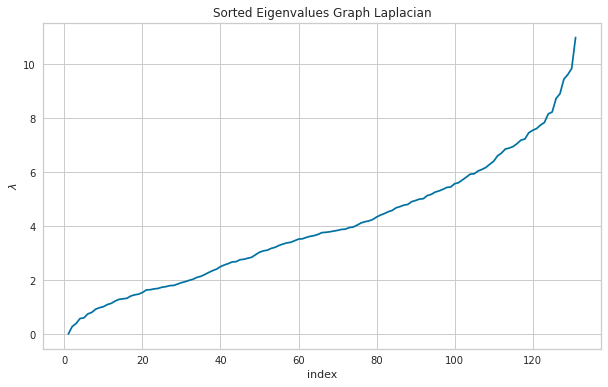

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=range(1, eigenvals_sorted_indices.size + 1), y=eigenvals_sorted, ax=ax)
ax.set(title='Sorted Eigenvalues Graph Laplacian', xlabel='index', ylabel=r'$\lambda$');

#### Find the Small Eigenvalues

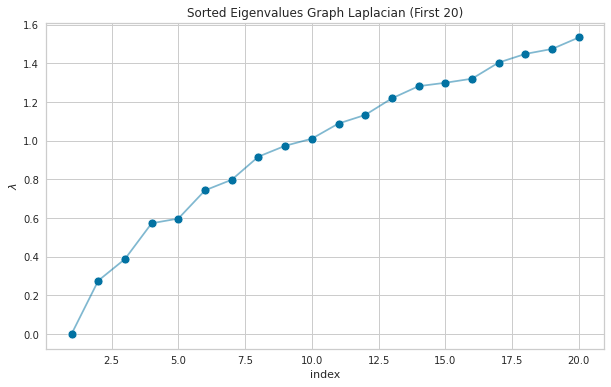

In [13]:
index_lim = 20

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], s=80, ax=ax)
sns.lineplot(x=range(1, eigenvals_sorted_indices[: index_lim].size + 1), y=eigenvals_sorted[: index_lim], alpha=0.5, ax=ax)
#ax.axvline(x=3, color='red', label='zero eigenvalues', linestyle='--')
ax.legend()
ax.set(title=f'Sorted Eigenvalues Graph Laplacian (First {index_lim})', xlabel='index', ylabel=r'$\lambda$');

Let's consider for instance the first 7 eigenvectors ordered by their eigenvalues.

In [14]:
eigenvals_index = np.argwhere(abs(eigenvals) < 0.8)
eigenvals[eigenvals_index]

array([[1.77635683e-15],
       [2.75925544e-01],
       [3.87904569e-01],
       [5.73046754e-01],
       [5.97285970e-01],
       [7.43517698e-01],
       [7.98327603e-01]])

In [15]:
proj_df = pd.DataFrame(eigenvcts[:, eigenvals_index.squeeze()])
proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
proj_df.head()

,v_0,v_1,v_2,v_3,v_4,v_5,v_6
0,-0.08737,0.039283,-0.112724,-0.055615,-0.000456,-0.071229,-0.004770
1,-0.08737,0.104654,0.055146,0.039624,-0.074227,-0.081813,-0.070208
2,-0.08737,0.066363,-0.093491,0.030825,-0.196301,0.031876,0.091626
3,-0.08737,0.038507,0.022251,0.224345,0.090166,-0.165607,-0.159236
4,-0.08737,0.025815,-0.119575,-0.100334,0.051698,0.002597,-0.050521


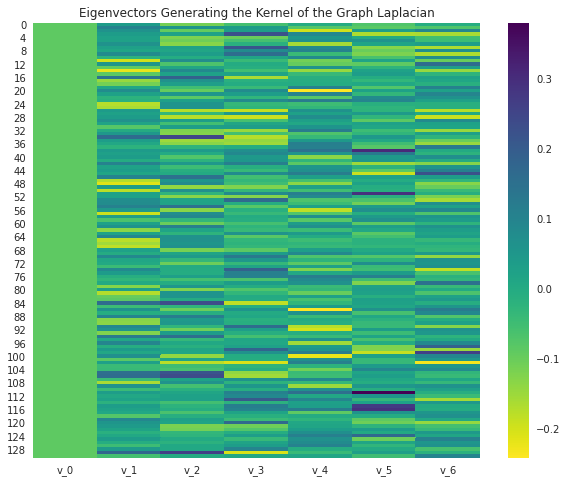

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(proj_df, ax=ax, cmap='viridis_r')
ax.set(title='Eigenvectors Generating the Kernel of the Graph Laplacian');

In [17]:
def project_and_transpose(eigenvals, eigenvcts, num_ev):
    """Select the eigenvectors corresponding to the first 
    (sorted) num_ev eigenvalues as columns in a data frame.
    """
    eigenvals_sorted_indices = np.argsort(eigenvals)
    indices = eigenvals_sorted_indices[: num_ev]

    proj_df = pd.DataFrame(eigenvcts[:, indices.squeeze()])
    proj_df.columns = ['v_' + str(c) for c in proj_df.columns]
    return proj_df

Identify the maximum gap which corresponds to the number of clusters by eigengap heuristic

In [18]:
index_largest_gap = np.argsort(np.diff(eigenvals))[::-1][:5]
nb_clusters = index_largest_gap + 1
nb_clusters

array([11, 18, 22, 26, 32])

Let's use the 12 first eigenvectors for performing KMeans

#### Run K-Means Clustering

To select the number of clusters we run k-means for various cluster values and plot the associated inertia (sum of squared distances of samples to their closest cluster center).

In [19]:
inertias = []

k_candidates = range(2, 20)
proj_df = project_and_transpose(eigenvals, eigenvcts, 12)

for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(proj_df)
    inertias.append(k_means.inertia_)

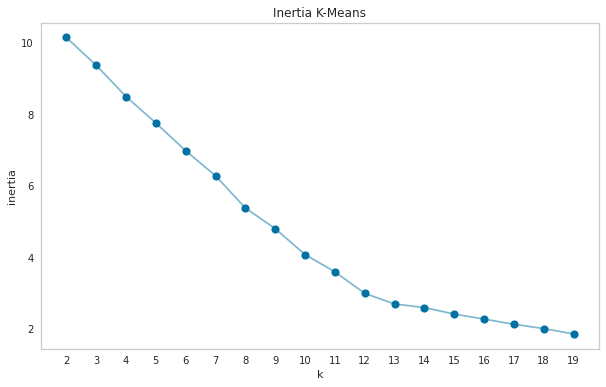

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=[str(i) for i in k_candidates], y = inertias, s=80, ax=ax)
sns.lineplot(x=[str(i) for i in k_candidates], y = inertias, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');
plt.grid(False)

In [21]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def shilouette_dim_reduction(data, vbles_emb, aux_boxplots, range_n_clusters = range(2, 20) ):
    avg_shilouette_scores = []
    plt.style.use('seaborn-whitegrid')
    range_n_clusters = range_n_clusters
    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        _ = ax1.set_xlim([-0.1, 1])
        _ = ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
            
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        avg_shilouette_scores.append(silhouette_avg)
        sample_silhouette_values = silhouette_samples(data, cluster_labels)
        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            _ = ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
            _ = ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10  # 10 for the 0 samples
        _ = ax1.set_title("The silhouette plot for the various clusters.")
        _ = ax1.set_xlabel("The silhouette coefficient values")
        _ = ax1.set_ylabel("Cluster label")
        _ = ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        _ = ax1.set_yticks([])  # Clear the yaxis labels / ticks
        _ = ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        _ = ax1.grid(False)
        #2nd plot
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        _ = ax2.scatter(vbles_emb[:,0], vbles_emb[:,1], s=30, c = colors, alpha=1)
        _ = ax2.grid(False)
        _ = ax2.axis('off')
        _ = ax2.set_title("The visualization of the clustered data.")
        _ = plt.suptitle("Silhouette analysis for KMeans clustering with n_clusters = {}. The average silhouette_score is {}".format(n_clusters, np.round(silhouette_avg, 3)),
                     fontsize=14, fontweight='bold')
        plt.show()
        
        fig = plt.figure(figsize=(20,7))
        df_edades = pd.DataFrame({'clust': cluster_labels, 'edad': aux_boxplots})
        sns.boxplot(x="clust", y="edad", data=df_edades)
        plt.grid(False)
    return pd.DataFrame({'clusters': list(range_n_clusters), 'Shilouette_avg': avg_shilouette_scores})

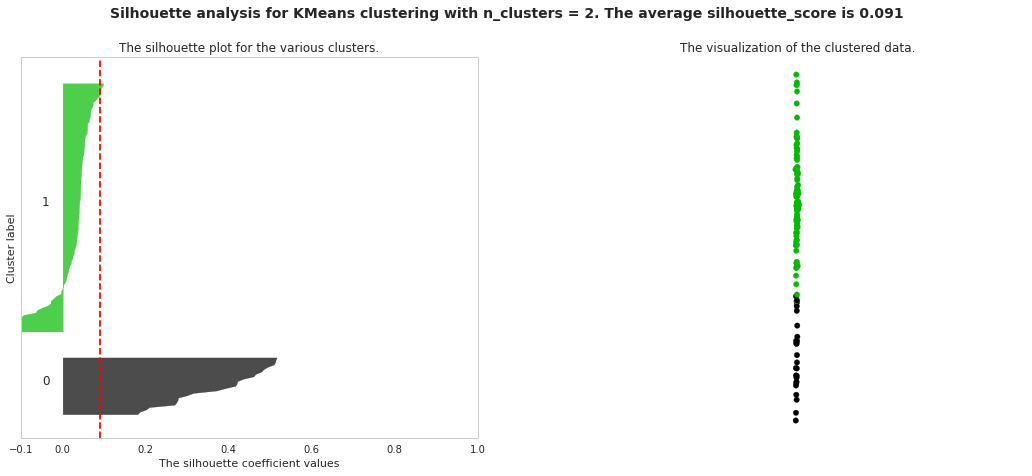

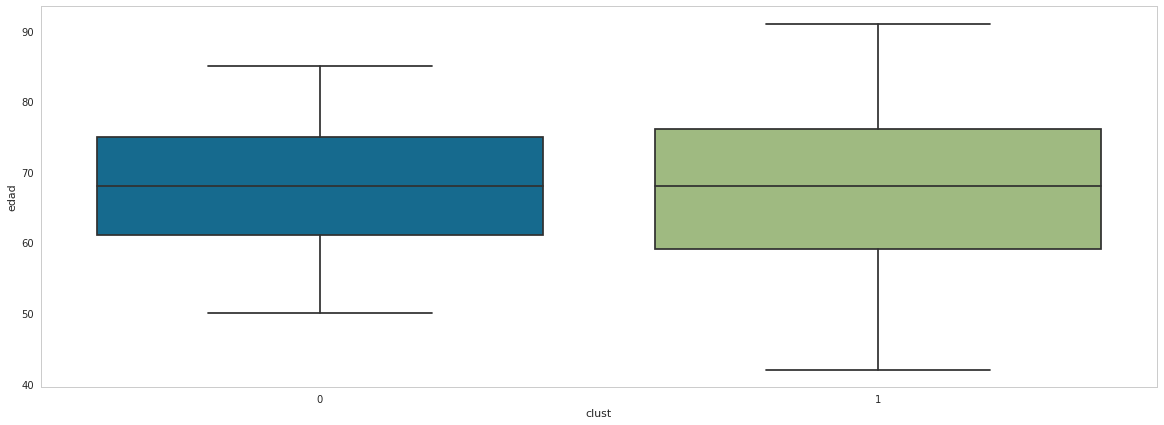

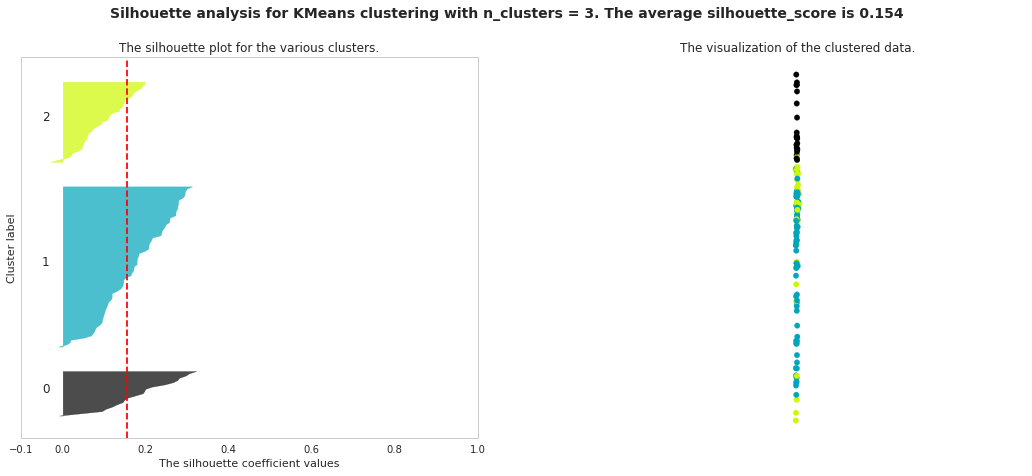

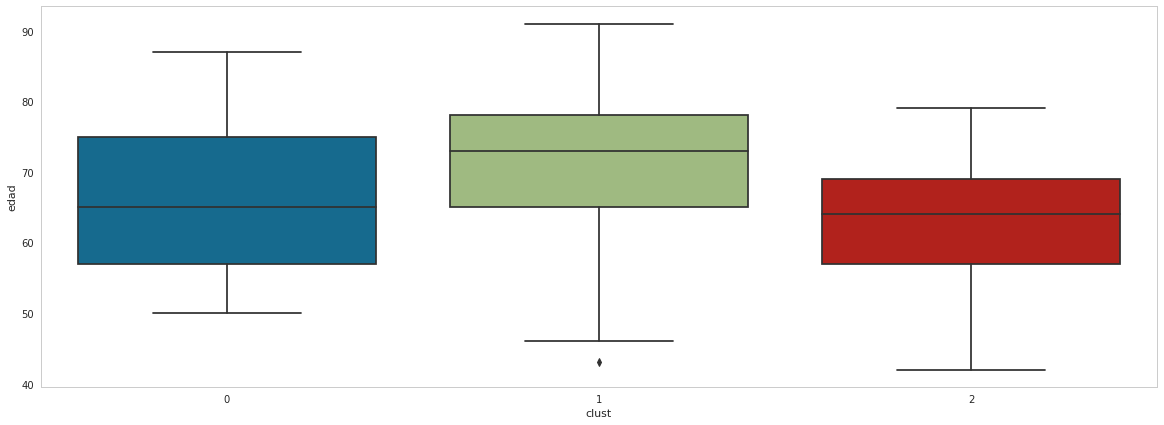

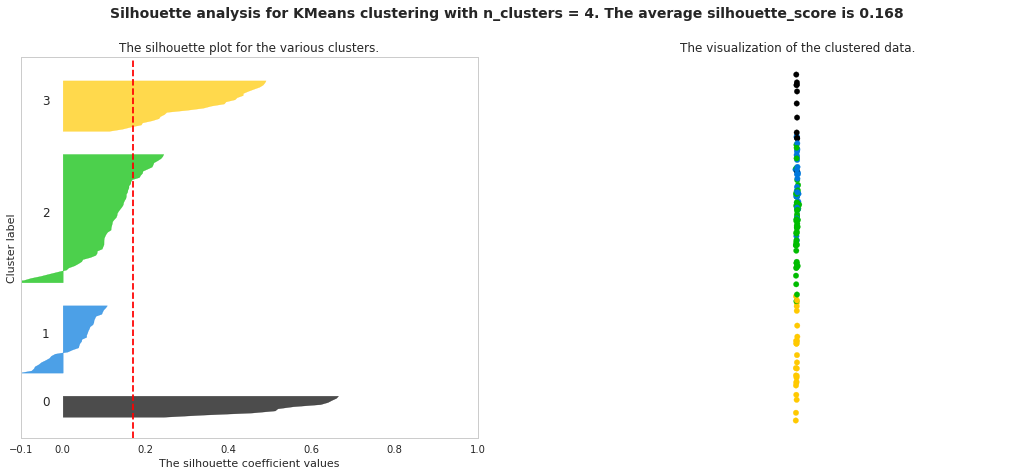

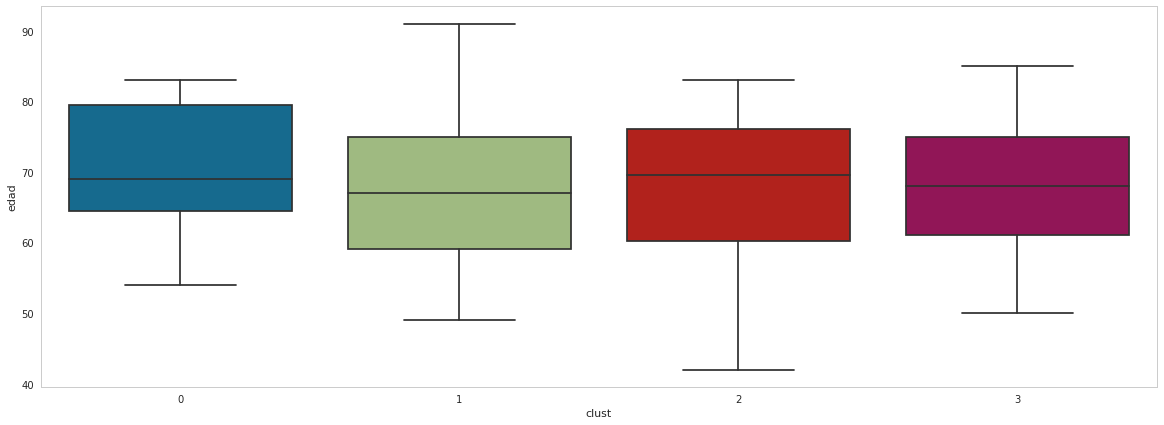

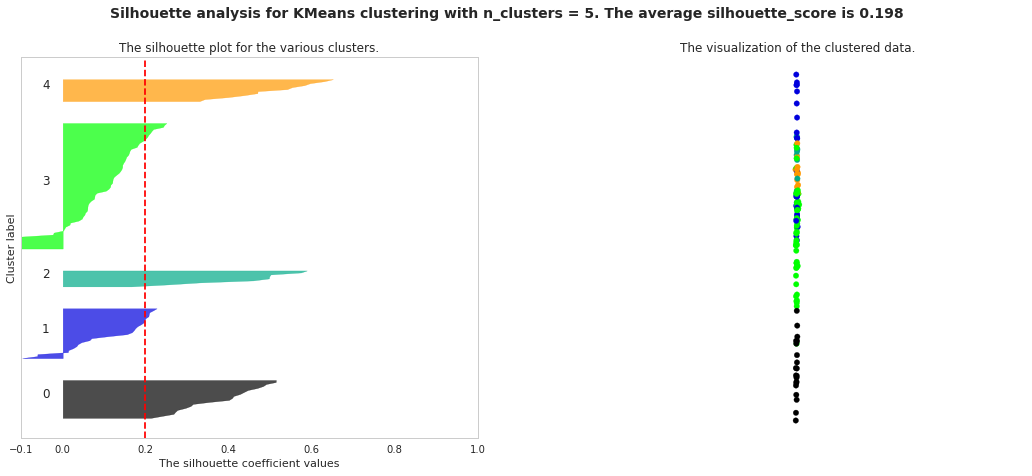

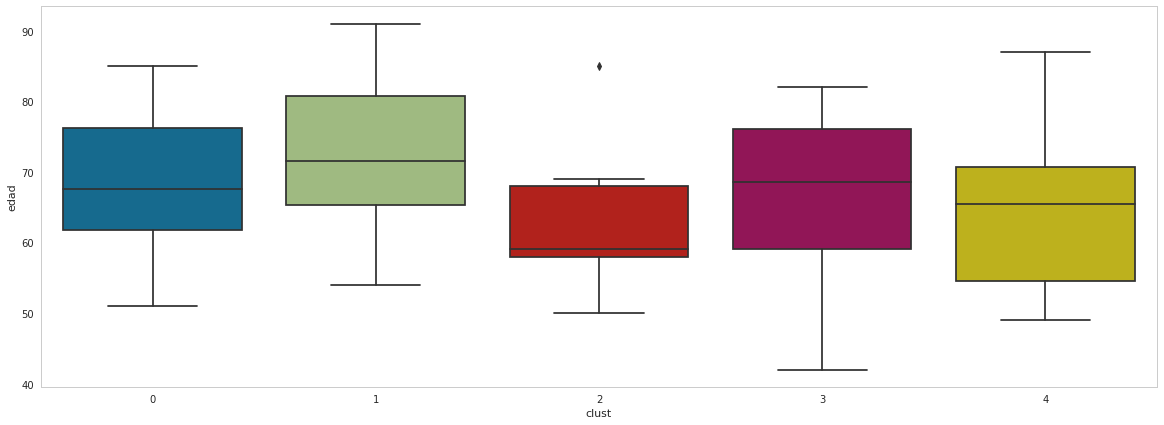

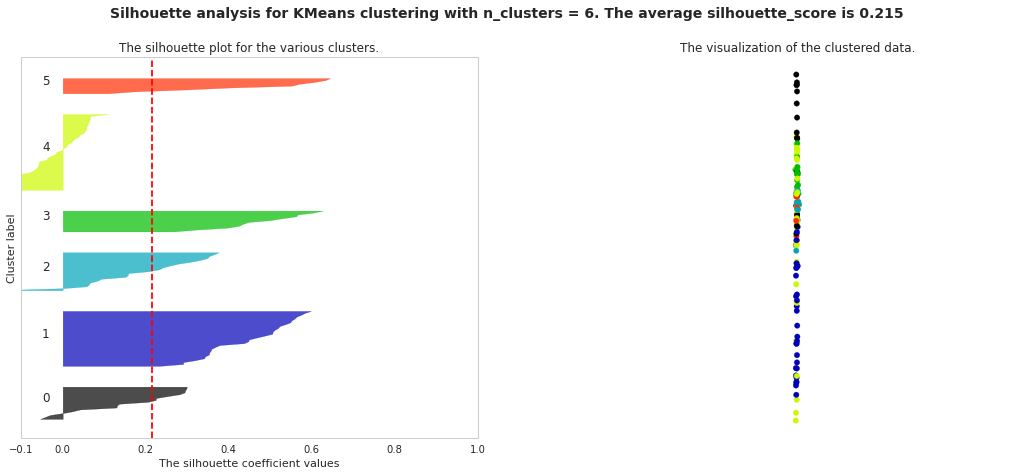

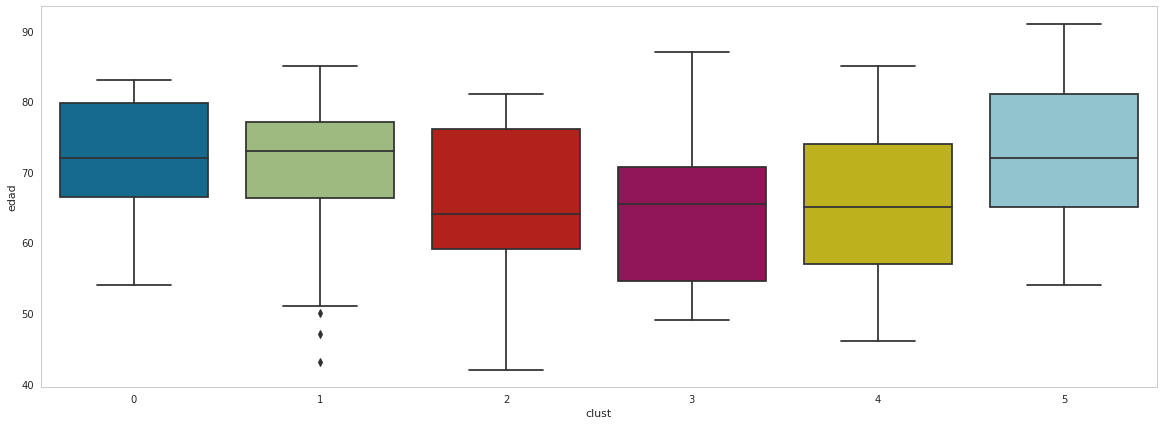

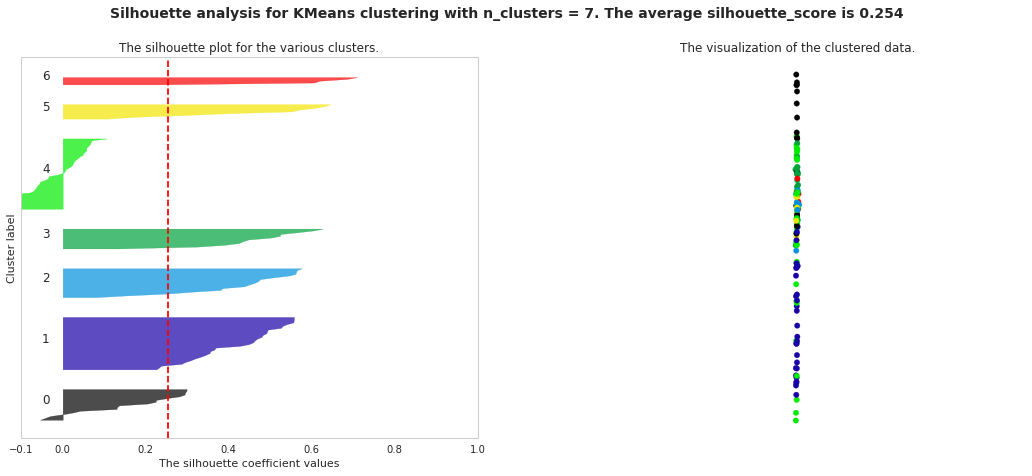

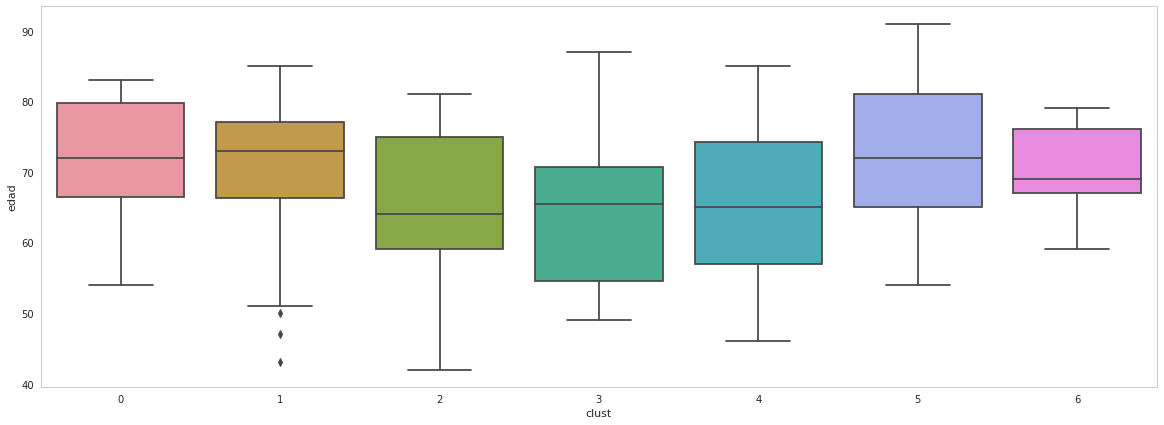

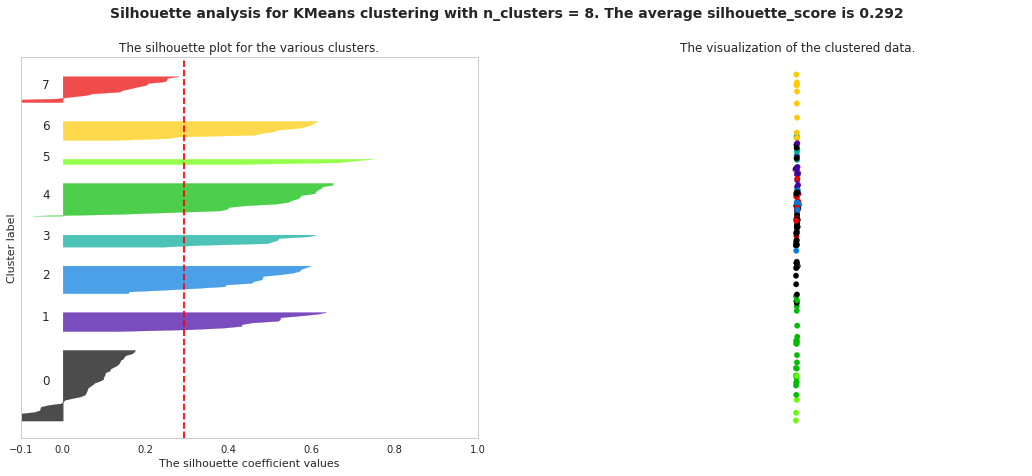

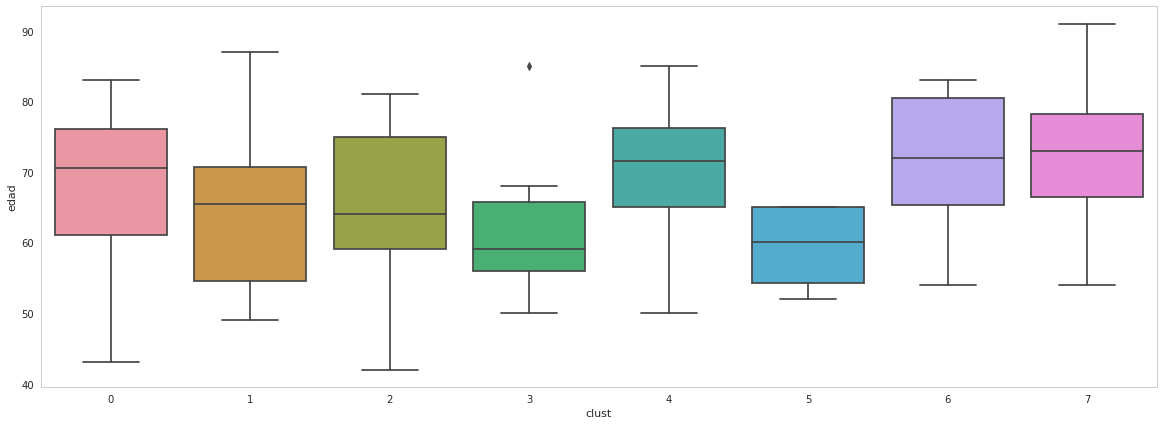

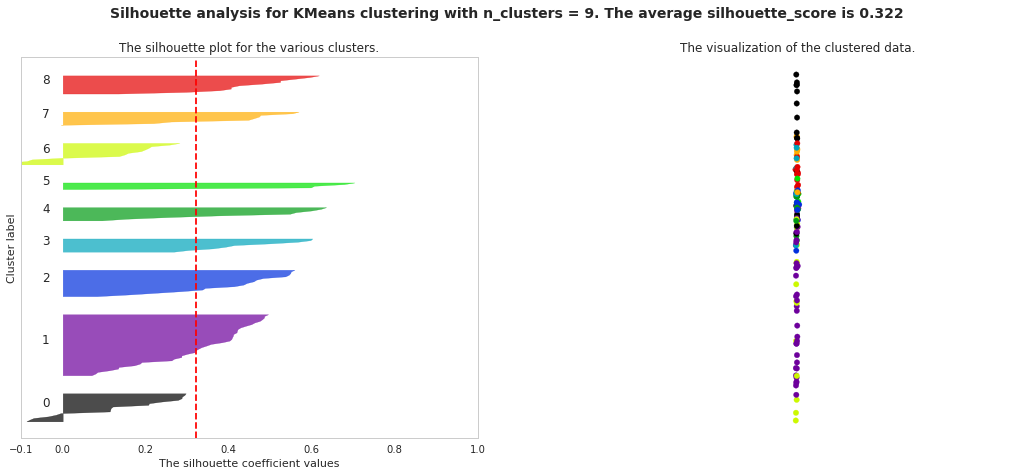

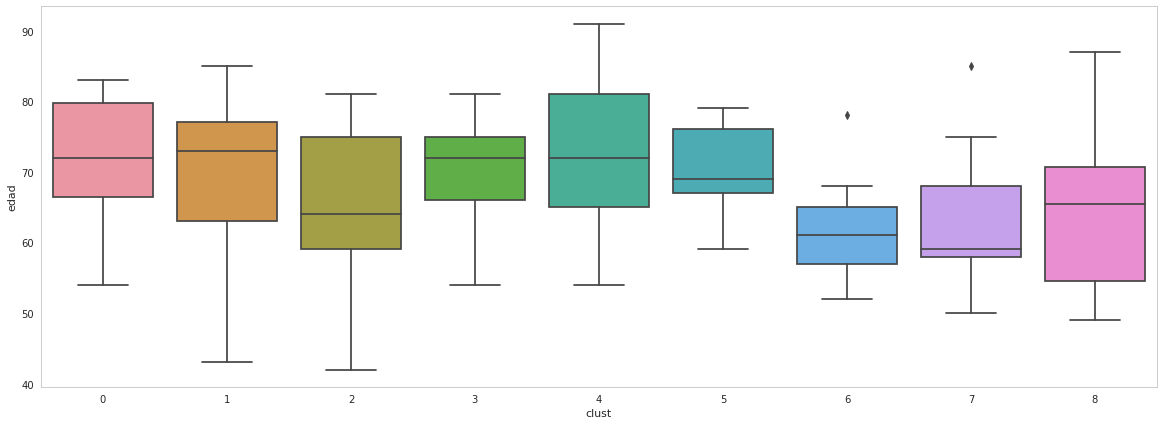

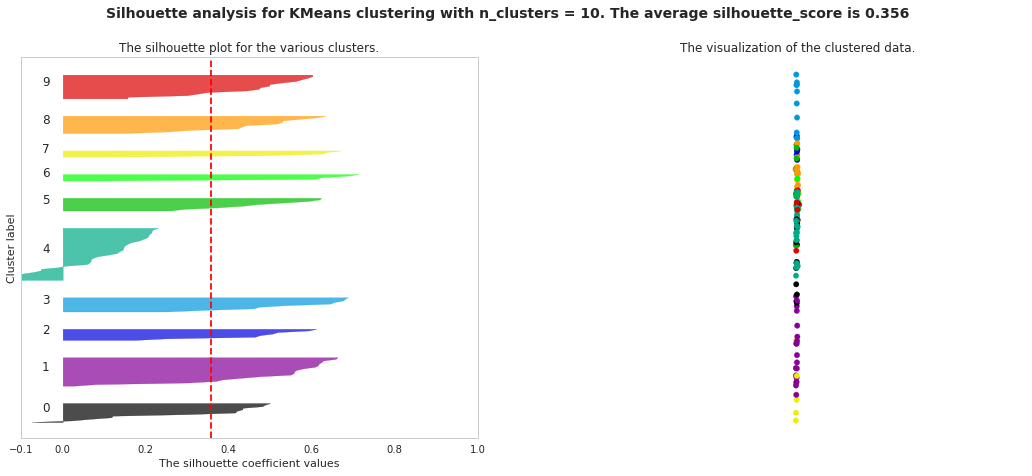

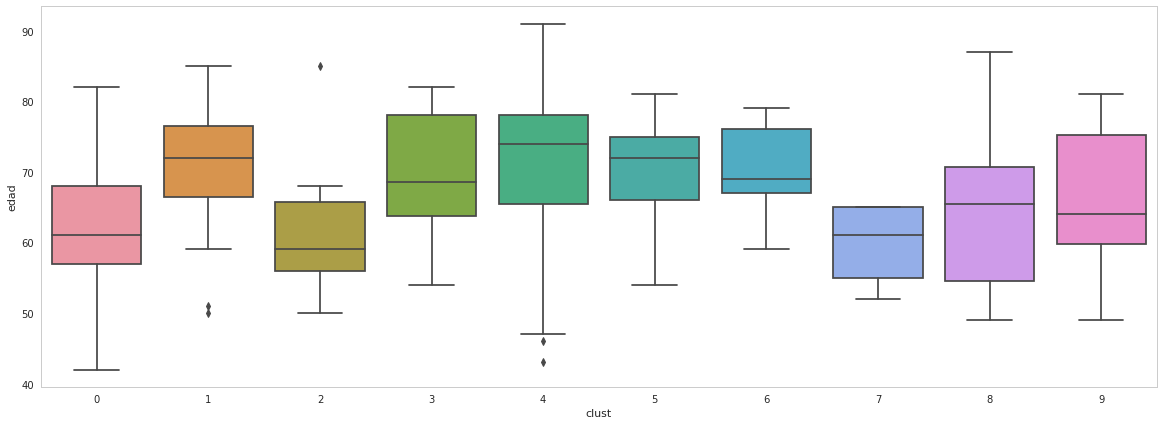

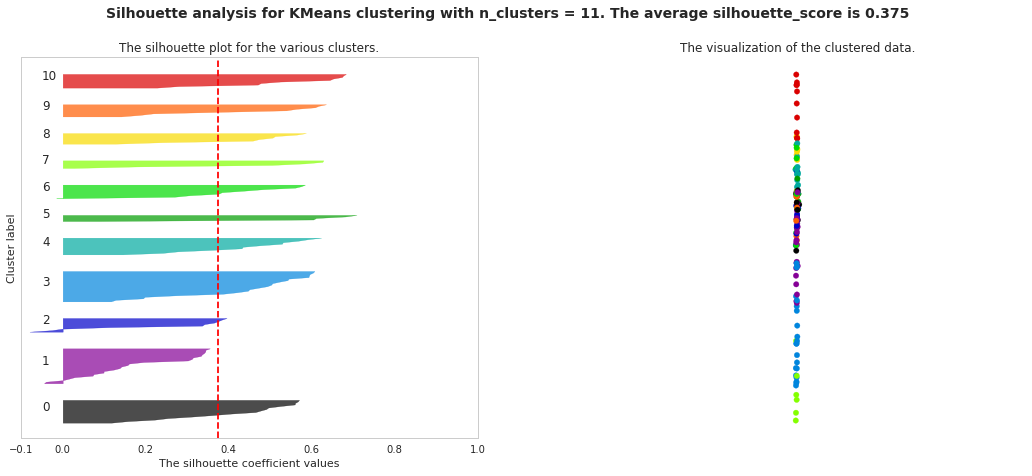

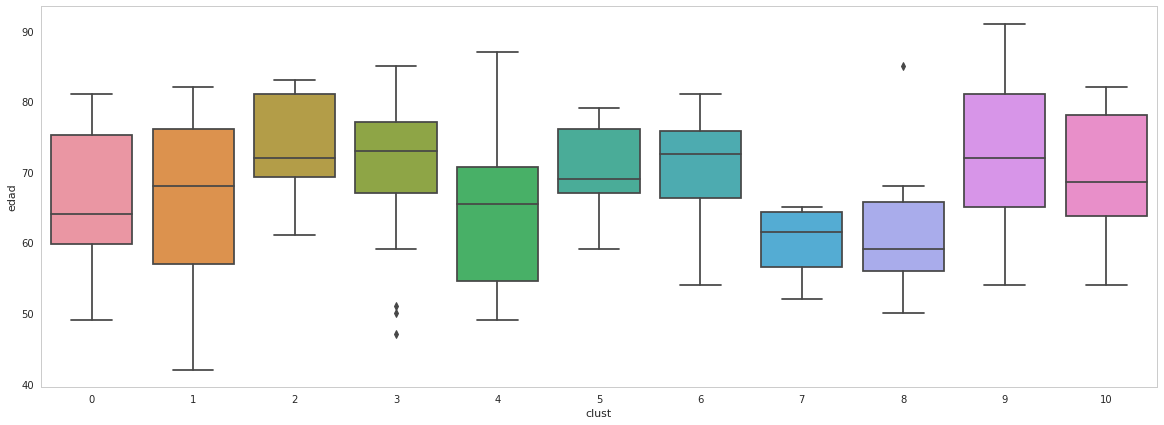

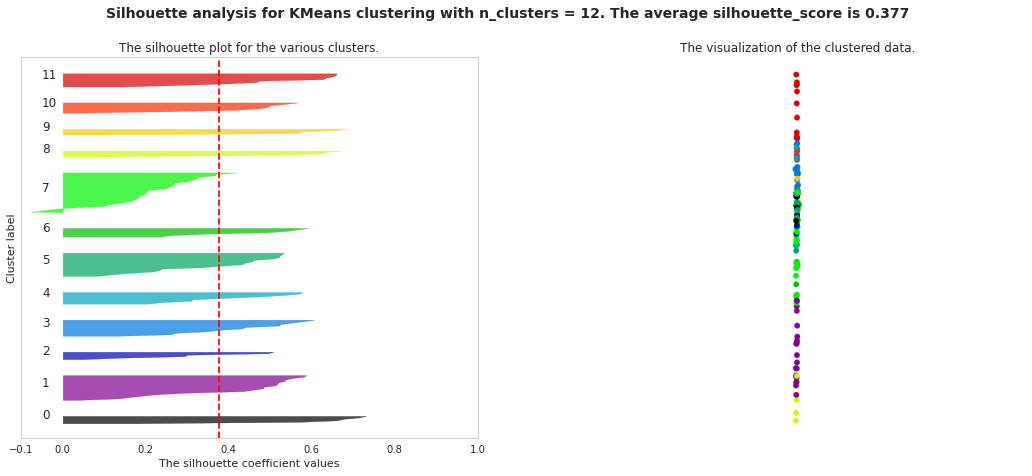

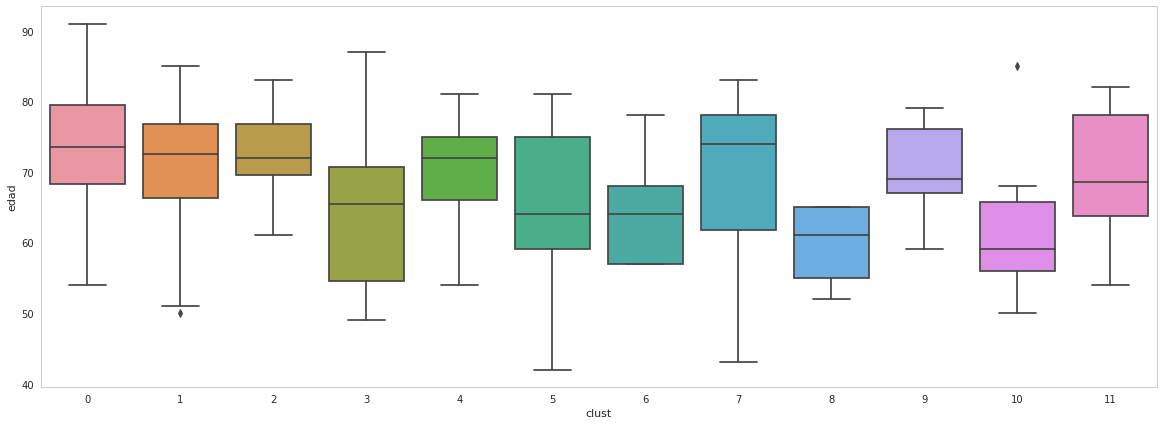

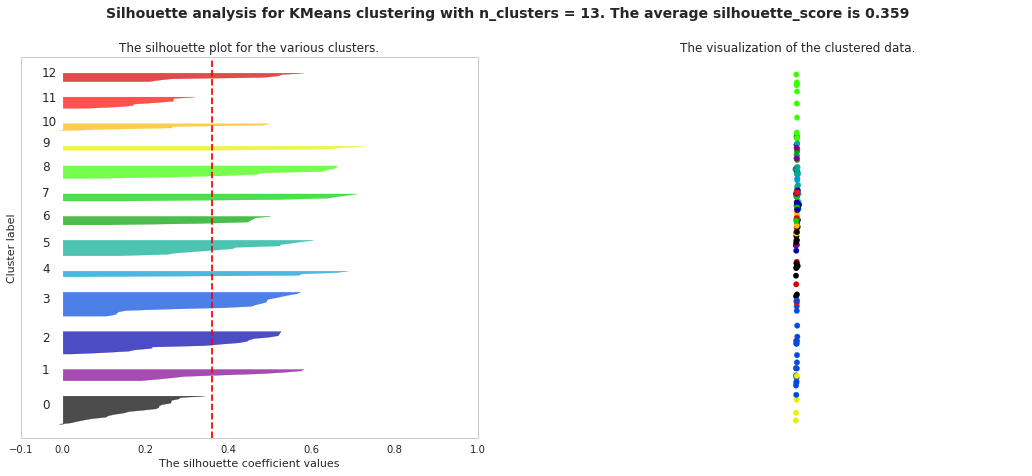

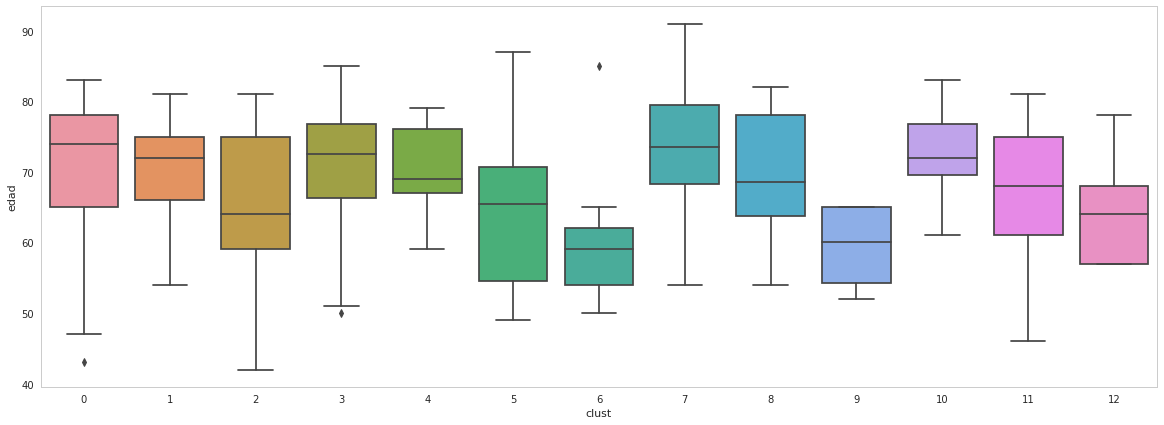

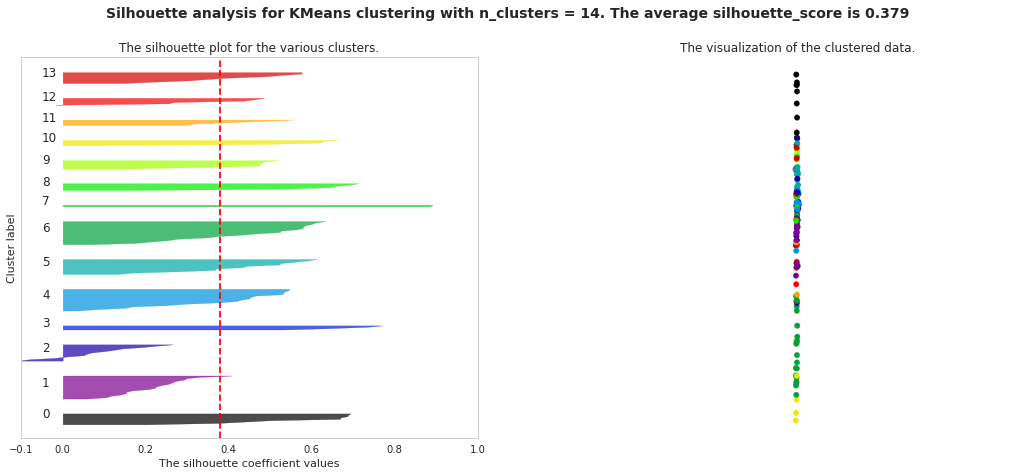

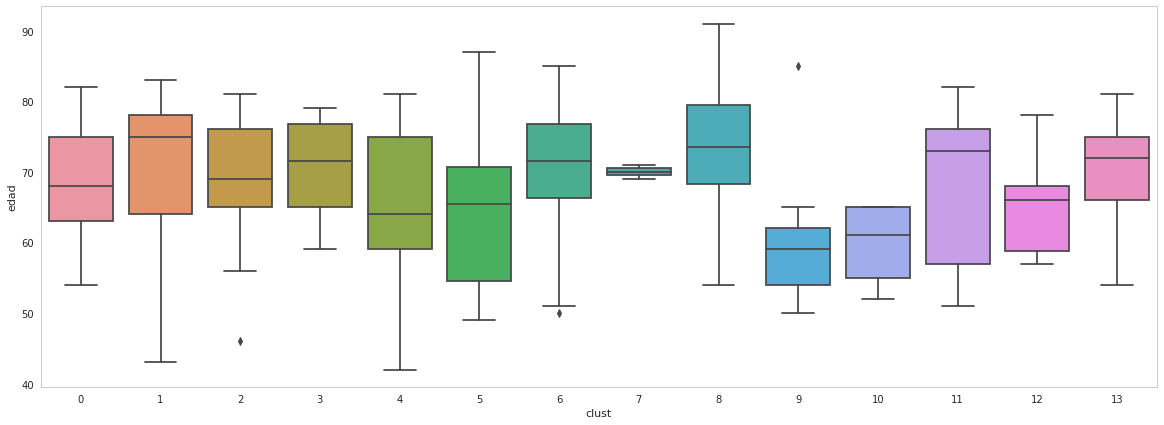

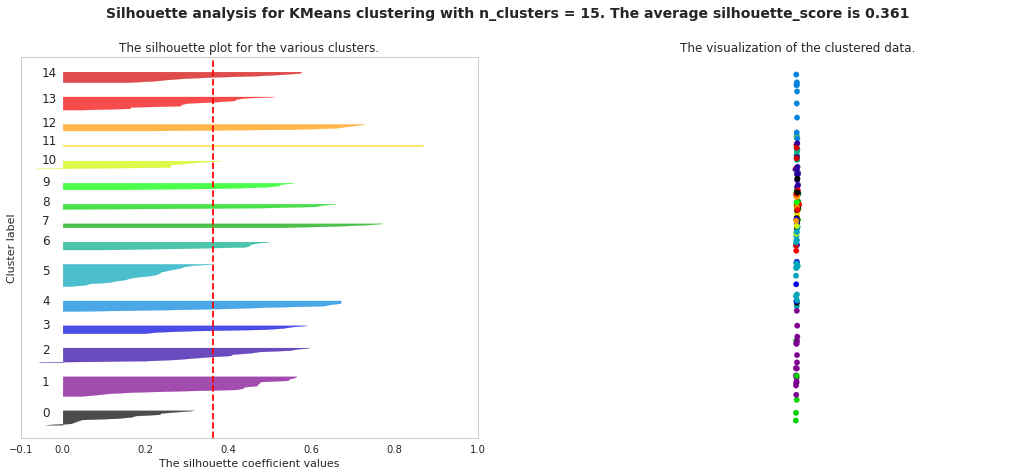

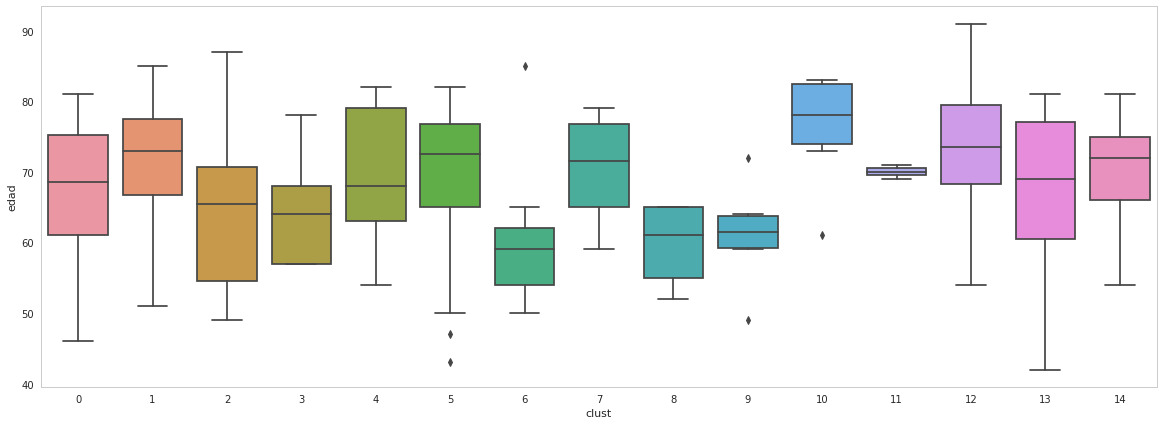

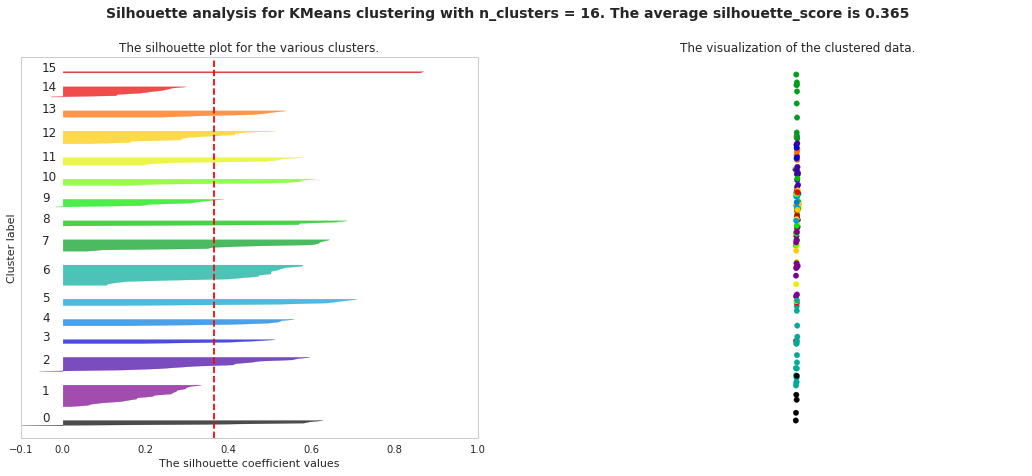

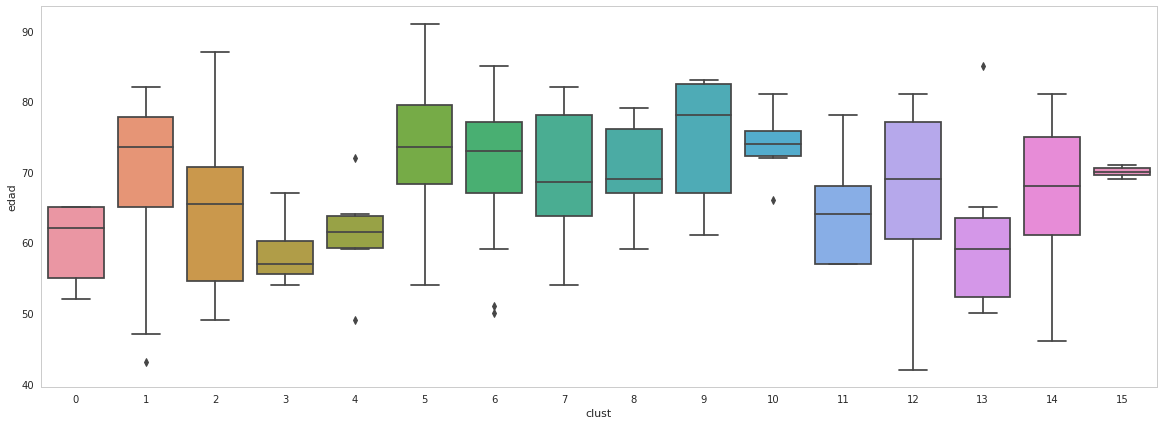

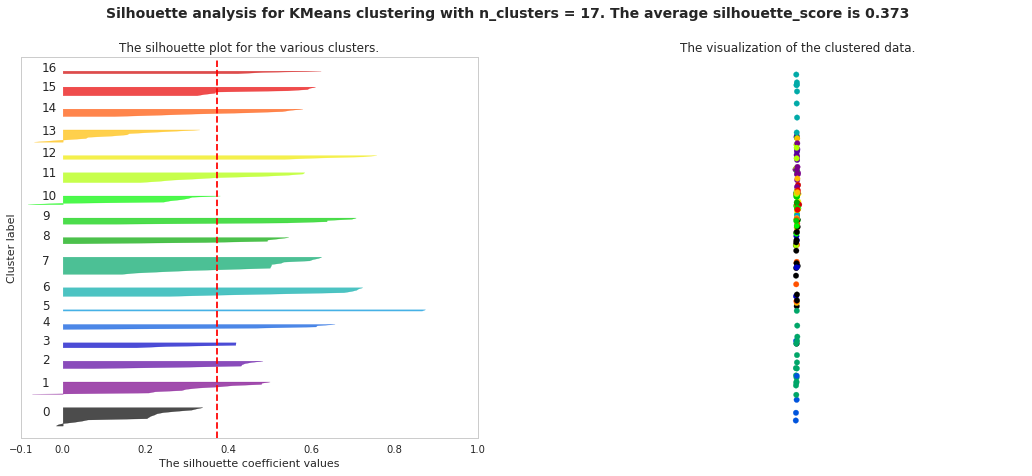

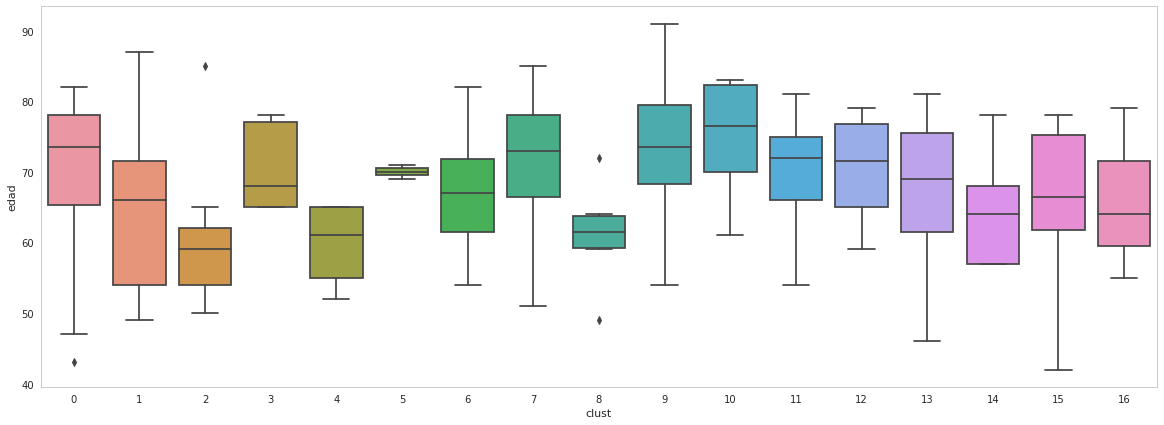

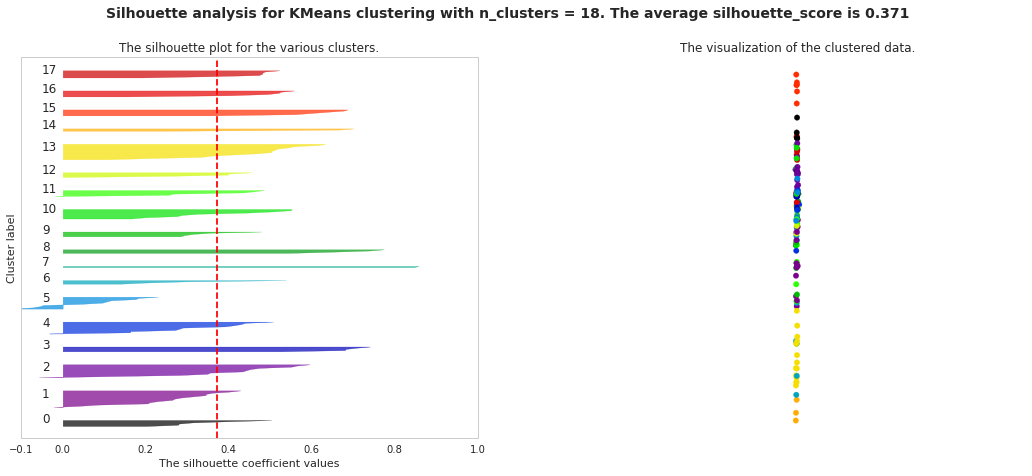

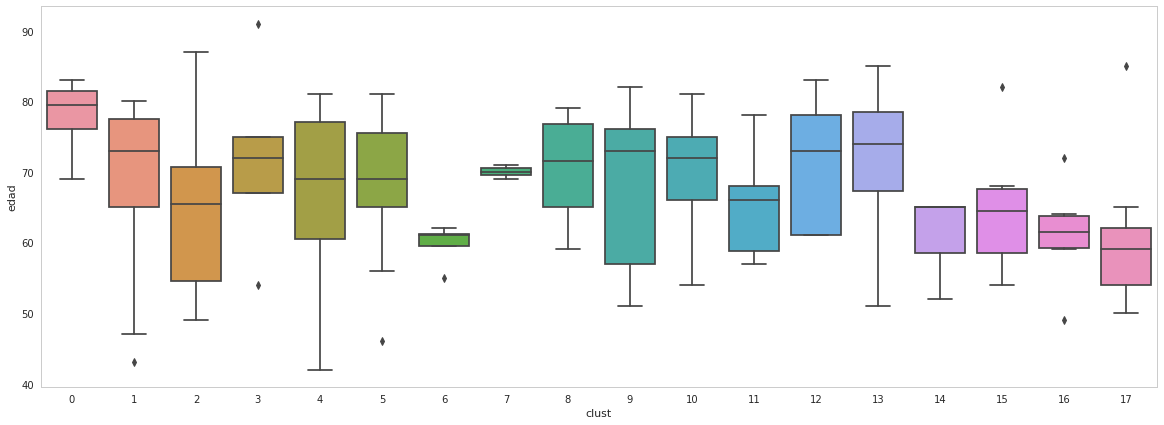

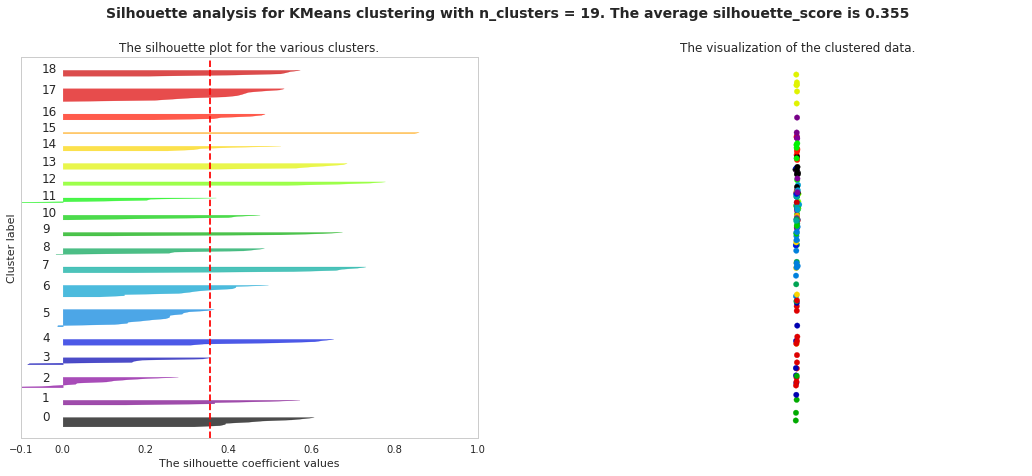

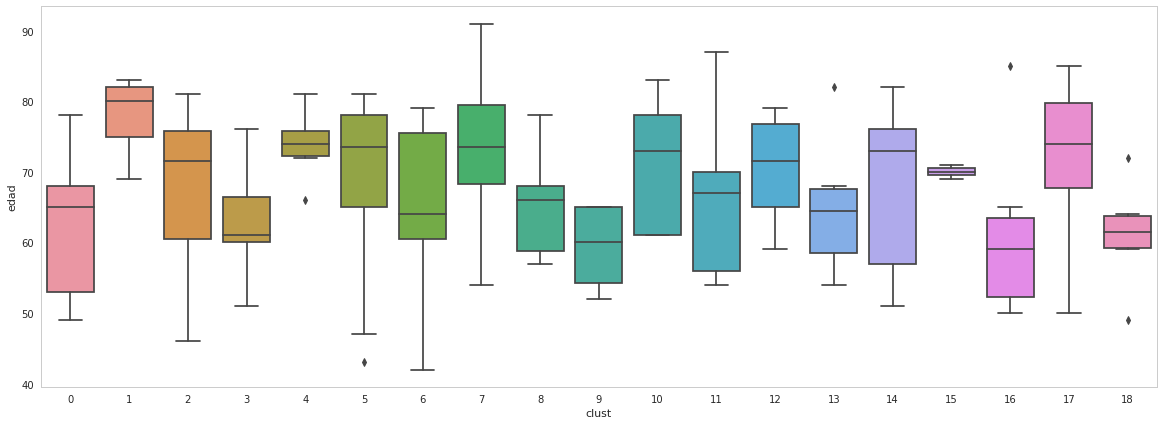

In [22]:
proj_df = project_and_transpose(eigenvals, eigenvcts, 11)
df_shil = shilouette_dim_reduction(proj_df, proj_df.values, aux_boxplots = df.Edad_dx,)

### GAP

In [23]:
from numpy.random import random_sample
from math import sqrt, log

# returns series of random values sampled between min and max values of passed col
def get_rand_data(col):
    rng = col.max() - col.min()
    return pd.Series(random_sample(len(col))*rng + col.min())

def iter_kmeans(df, n_clusters, num_iters=5):
    rng =  range(1, num_iters + 1)
    vals = pd.Series(index=rng)
    for i in rng:
        k = KMeans(n_clusters=n_clusters, n_init=44)
        k.fit(df)
        vals[i] = k.inertia_
    return vals

def gap_statistic(df, max_k=10):
    gaps = pd.Series(index = range(1, max_k + 1))
    for k in range(1, max_k + 1):
        km_act = KMeans(n_clusters=k, n_init=44)
        km_act.fit(df)

        # get ref dataset
        ref = df.apply(get_rand_data)
        ref_inertia = iter_kmeans(ref, n_clusters=k).mean()

        gap = log(ref_inertia) - log(km_act.inertia_)

        gaps[k] = gap
    return gaps

In [24]:
gaps = gap_statistic(proj_df, max_k = 20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dt

In [25]:
df_shil['WSS'] = inertias
df_shil['GAP'] = gaps[1:19].values
df_shil['clusters'] = df_shil['clusters'].astype(str)
df_shil.head(20)

,clusters,Shilouette_avg,WSS,GAP
0,2,0.090552,10.140663,1.000241
1,3,0.153802,9.363451,1.031146
2,4,0.168362,8.489571,1.018187
3,5,0.197595,7.749063,1.075595
4,6,0.215290,6.973537,1.090670
5,7,0.253852,6.273519,1.183303
6,8,0.292257,5.373370,1.348822
7,9,0.321752,4.794398,1.429386
8,10,0.356453,4.071117,1.645823
9,11,0.375151,3.586481,1.775556


In [26]:
df_shil.to_excel('resultados_spectral_clustering.xlsx')

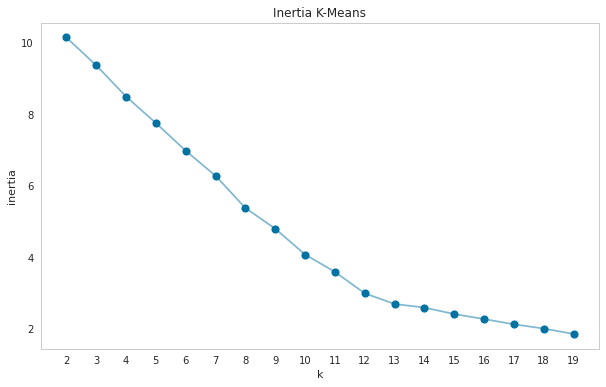

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=df_shil.clusters, y = inertias, s=80, ax=ax)
sns.lineplot(x=df_shil.clusters, y = df_shil.WSS, alpha=0.5, ax=ax)
ax.set(title='Inertia K-Means', ylabel='inertia', xlabel='k');
plt.grid(False)

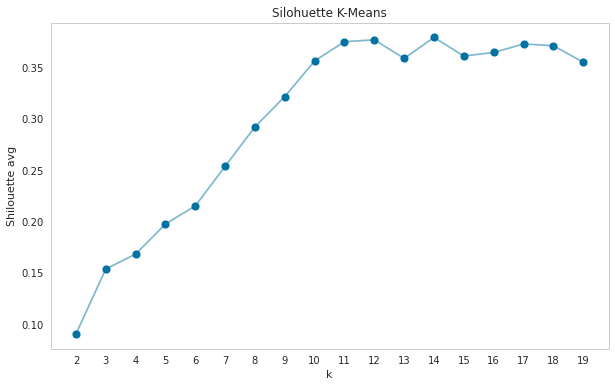

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=df_shil.clusters, y = df_shil.Shilouette_avg, s=80, ax=ax)
sns.lineplot(x=df_shil.clusters, y = df_shil.Shilouette_avg, alpha=0.5, ax=ax)
ax.set(title='Silohuette K-Means', ylabel='Shilouette avg', xlabel='k');
plt.grid(False)

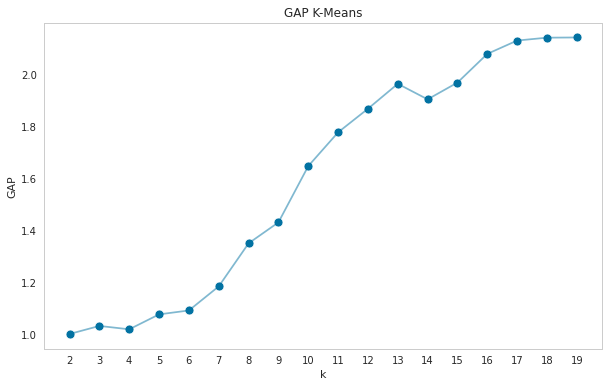

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(x=df_shil.clusters, y = df_shil.GAP, s=80, ax=ax)
sns.lineplot(x=df_shil.clusters, y = df_shil.GAP, alpha=0.5, ax=ax)
ax.set(title='GAP K-Means', ylabel='GAP', xlabel='k');
plt.grid(False)

10 clusters seems to be the best number of clusters.

In [30]:
import plotly.express as px
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(proj_df)
clusters = kmeans.labels_

#fig = px.scatter_3d(x=le_embedding[:,0], y=le_embedding[:,1], z=le_embedding[:,2],
              #color=clusters.astype('str'))
#fig.show()

In [31]:
pd.DataFrame(clusters, columns = ['Clusters']).to_excel('Clusters.xlsx')

### Shilouette

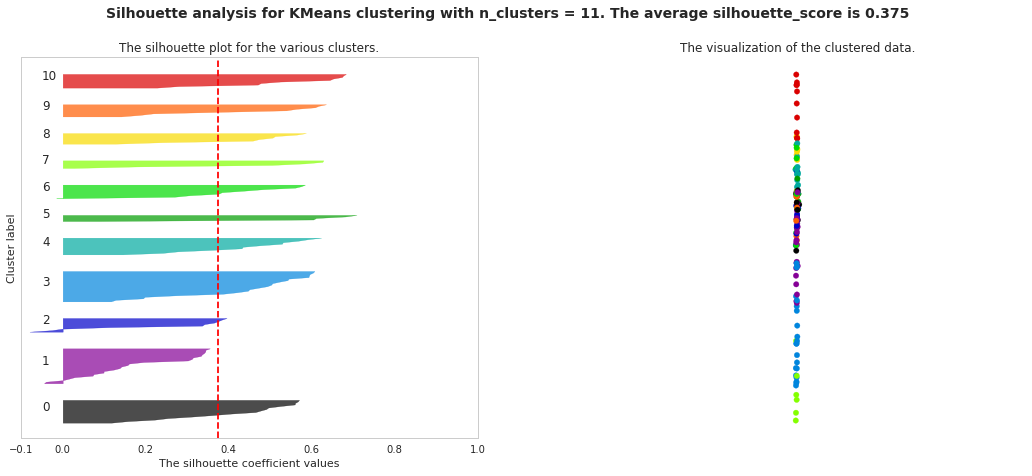

,clusters,Shilouette_avg
0,11,0.375151


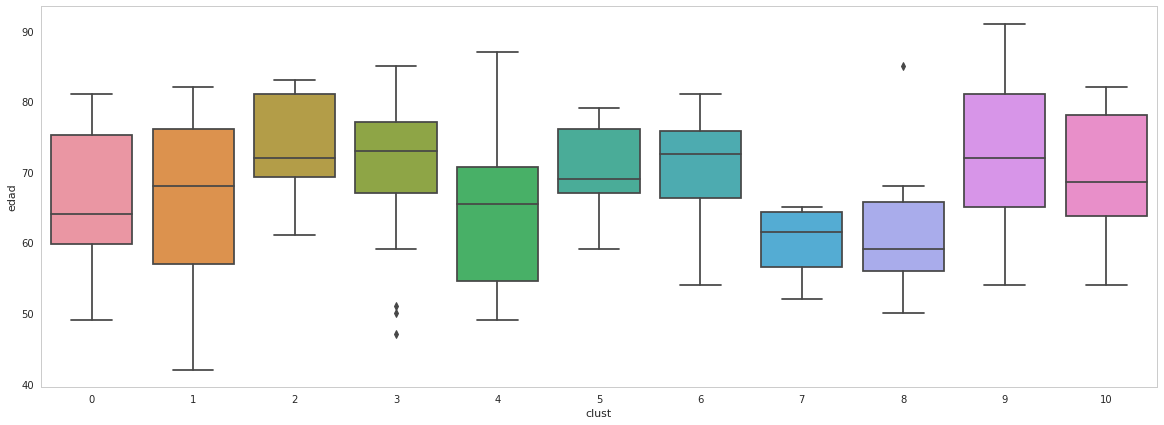

In [32]:
shilouette_dim_reduction(proj_df, proj_df.values, aux_boxplots = df.Edad_dx, range_n_clusters = range(11,12))

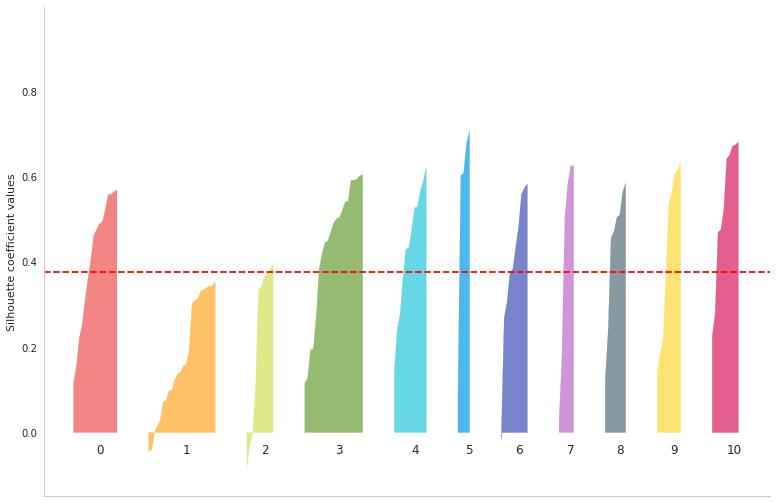

In [33]:
avg_shilouette_scores = []
n_clusters = 11
clusterer = KMeans(n_clusters=11, random_state=42)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(13, 9)
_ = ax1.set_ylim([-0.15, 1])
_ = ax1.set_xlim([0, len(X) + (n_clusters + 1) * 10])
        
cluster_labels = clusterer.fit_predict(proj_df)
silhouette_avg = silhouette_score(proj_df, cluster_labels)
avg_shilouette_scores.append(silhouette_avg)
sample_silhouette_values = silhouette_samples(proj_df, cluster_labels)
y_lower = 10
colors = ['#ef5350', '#FFA726', '#D4E157', '#689F38', '#26C6DA', '#039BE5', 
          '#3F51B5', '#BA68C8', '#546E7A', '#FDD835', '#D81B60', '#4DD0E1']
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = colors[i]
    _ = ax1.fill_between(x = np.arange(y_lower, y_upper),
                              y1 = 0, y2 = ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)
    _ = ax1.text(y = -0.05, x = y_lower + 0.5 * size_cluster_i, s = str(i))
    y_lower = y_upper + 10  # 10 for the 0 samples
_ = ax1.set_ylabel("Silhouette coefficient values")
_ = ax1.axhline(silhouette_avg, color="red", linestyle="--")
_ = ax1.set_xticks([])  # Clear the yaxis labels / ticks
_ = ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8])
_ = ax1.grid(False)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
plt.savefig('sil_plot.png', bbox_inches='tight')
plt.show()